# cs8321 Lab 1 - ConceptNet Ethics Testing

#### Chip Henderson - 48996654


In [36]:
# Import everything
import numpy as np
import pandas as pd
import matplotlib
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Input, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Subtract
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
import seaborn
import re
from sklearn.metrics import accuracy_score



### Intro

In this notebook I'm going to be comparing the results from our in-class discussion and modeling to my results when using a trained transformer. This code is set up to run in google colab so some parts need to be commented out when running on my local system.

In [37]:
# Uncomment for use in colab
# from google.colab import drive
# drive.mount('/content/drive/')

In [38]:
%%time
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

# embeddings = load_embeddings('data/glove.840B.300d.txt') # course original
embeddings = load_embeddings('../Data_Sources/numberbatch-en.txt') # local PC
embeddings.shape

CPU times: total: 32.7 s
Wall time: 37.1 s


(516782, 300)

In [39]:
# Source: In class notebook 01 ConceptNet
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.

    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

# For running on local system, use the following:
pos_words = load_lexicon('../Data_Sources/positive-words.txt')
neg_words = load_lexicon('../Data_Sources/negative-words.txt')

# For running in colab, use the following:
# pos_words = load_lexicon(r'/content/drive/MyDrive/Colab Notebooks/positive-words.txt') # colab version
# neg_words = load_lexicon(r'/content/drive/MyDrive/Colab Notebooks/negative-words.txt') # colab version

print(len(pos_words), len(neg_words))

2006 4783


In [40]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Ellen', 'Lauren', 'Peggy', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Torrance', 'Darnell', 'Lamar', 'Lionel',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone',
        'Lavon', 'Marcellus', 'Wardell', #'Nichelle',
        'Ebony', 'Shaniqua',
        'Jasmine', 'Tanisha', 'Tia', 'Latoya',
        'Yolanda', 'Malika', 'Yvette'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Jorge', 'Santiago',
        'Mateo',  'Alejandro', 'Samuel', 'Diego', 'Daniel',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding

    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Syed', 'Samar', 'Ahmad', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

In [41]:
# # print(NAMES_BY_ETHNICITY.values())
# full_name_list = []
# for list in NAMES_BY_ETHNICITY.values():
#     for name in list:
#         full_name_list.append(name)

# print(len(full_name_list))

Note, vecs_to_sentiment is where the model prediction call is coming from in this code

In [42]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier,
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

In [43]:
import scipy.stats as stats

def retrain_model(new_embs, title = ''):
    """
    Repeat the steps above with a new set of word embeddings.
    """
    # use these from outside the function and update them globally
    global model, embeddings, name_sentiments
    embeddings = new_embs
    # get the positive and negative embeddings
    pos_words_common = list(set(pos_words) & set(embeddings.index))
    neg_words_common = list(set(neg_words) & set(embeddings.index))
    pos_vectors = embeddings.loc[pos_words_common]
    neg_vectors = embeddings.loc[neg_words_common]
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    # split the data
    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

    # train our model
    model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
    model.fit(train_vectors, train_targets)

    # print out a goodness of fit
    accuracy = accuracy_score(model.predict(test_vectors), test_targets)
    print("Accuracy of sentiment: {:.2%}".format(accuracy))

    # get the name table of different people's names and save embeddings
    name_sentiments = name_sentiment_table()

    stats.f_oneway(
        name_sentiments['sentiment'][name_sentiments['group'] == 'White'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Black'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Hispanic'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Arab/Muslim'],
    )

    name_sentiments = name_sentiment_table()

    fstat,pval = stats.f_oneway(
        name_sentiments['sentiment'][name_sentiments['group'] == 'White'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Black'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Hispanic'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Arab/Muslim'],
    )
    print('F-statistic:',fstat,' With P-value:', pval)

    # Show the results on a swarm plot, with a consistent Y-axis
    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.subplot(121)
    plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
    plot.set_ylim([-10, 10])
    matplotlib.pyplot.subplot(122)
    plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)
    matplotlib.pyplot.suptitle(title, fontsize=16)

    print(fstat)

Accuracy of sentiment: 97.47%
F-statistic: 12.758074308288405  With P-value: 2.5815692560199287e-07
12.758074308288405


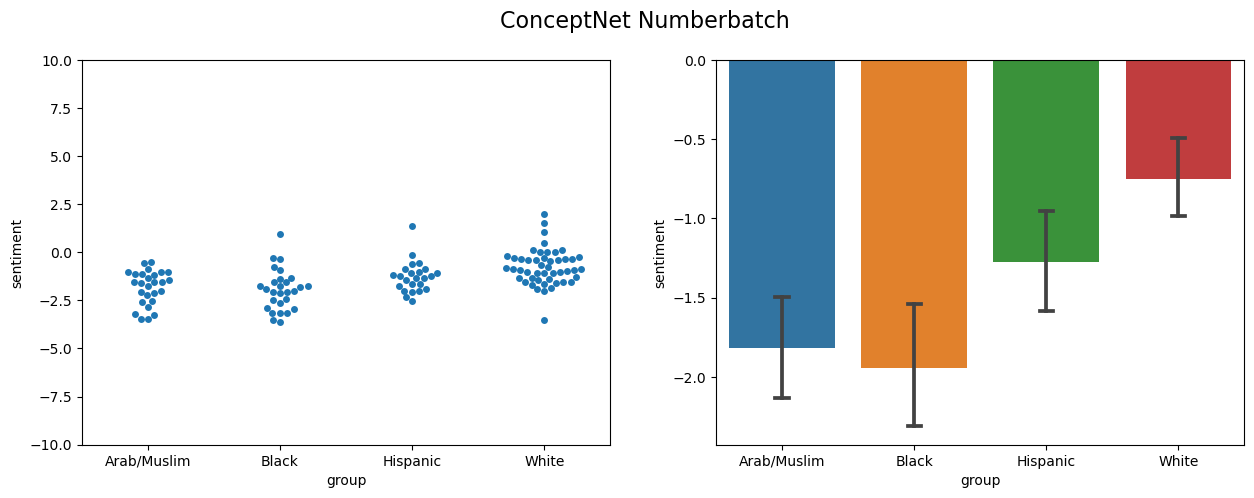

In [44]:
# Local PC version
retrain_model(load_embeddings('../Data_Sources/numberbatch-en.txt'), title='ConceptNet Numberbatch')
# Colab version
# retrain_model(load_embeddings('/content/drive/MyDrive/Colab Notebooks/numberbatch-en.txt'), title='ConceptNet Numberbatch')

### Import and prepare the data for model training

In this section of code I'm going to be training a transformer on the same lexicon used in the ConceptNet notebook from class. I'm going to manipulate some of the training data to make it compatible with the transformer. Instead of feeding in the actual word vectors as found in the embedding of choice, I need the words themselves, tokenized and one-hot encoded. They'll also be zero padded to ensure all entries are the same length.

## CNN

In [45]:
# Source: Modified from notebook 01 ConceptNet
pos_words_common = list(set(pos_words) & set(embeddings.index))
neg_words_common = list(set(neg_words) & set(embeddings.index))

# I'll need the following to execute the code from class.
# But, they won't play a role in my transformer training.
pos_vectors = embeddings.loc[pos_words_common]
neg_vectors = embeddings.loc[neg_words_common]

# For the transformer I'm using the words themslves, not the vectors
words = pos_words_common + neg_words_common

# This portion is test code
vectors = pd.concat([pos_vectors, neg_vectors])

# Source: ChatGPT to help with conversion from pd dataframe to dataset
# train_ds = tf.data.Dataset.from_tensor_slices((train_vectors, train_targets))
# test_ds = tf.data.Dataset.from_tensor_slices((test_vectors, test_targets))


In [46]:
# Source: in class notebook 01 ConceptNet
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [47]:
vectors.head() # debug

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
abundance,-0.0818,0.0471,0.0071,-0.0659,0.0422,0.0486,0.1998,0.1988,0.2046,-0.0242,...,-0.0286,0.0754,0.0052,-0.0433,0.0232,-0.0083,-0.0255,0.0066,0.0043,0.0570
glitter,-0.1068,-0.0003,0.1912,0.0062,-0.0046,-0.0910,0.2369,0.0408,0.0027,0.0973,...,-0.0061,-0.0326,0.0155,0.0097,0.0182,0.0587,-0.0221,-0.0280,0.0236,-0.0327
righteousness,-0.0941,-0.1014,-0.0926,-0.1530,-0.0695,0.0212,0.1215,0.1311,-0.0862,-0.0342,...,-0.0467,-0.0307,-0.0402,0.0791,-0.0321,0.0864,0.0067,0.0192,-0.0318,0.0377
tenaciously,-0.0582,-0.0576,0.0081,-0.0816,0.0543,-0.0880,0.0321,0.1341,-0.0312,-0.0994,...,0.0816,-0.0104,-0.0307,-0.0029,0.0237,0.0350,-0.0079,0.0220,0.0218,0.0243
trust,-0.1082,-0.1285,-0.1097,0.0206,-0.0065,0.1398,0.0139,0.0170,-0.0009,-0.1074,...,0.0085,-0.0005,-0.0606,-0.0217,0.0176,0.0006,-0.0334,-0.0508,0.0006,-0.0373


In [48]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [49]:
print(test_targets.shape)

(632,)


In [50]:
# Source: modified from Notebook 13a cs7324

# One hot encode the target values
train_targets_ohe = keras.utils.to_categorical(train_targets)
test_targets_ohe = keras.utils.to_categorical(test_targets)

# Convert the training and testing data to tensorflow datasets
# train_ds = tf.data.Dataset.from_tensor_slices((train_vectors, train_targets))
# test_ds = tf.data.Dataset.from_tensor_slices((test_vectors, test_targets))

X_train = train_vectors.values
X_test = test_vectors.values

# Check the shape of the data and labels to ensure they are correct
print('Shape of data tensor train:', X_train.shape)
print('Shape of data tensor for test:', X_test.shape)
print('Shape of target tensor train:', train_targets_ohe.shape)
print('Shape of target tensor for test:', test_targets_ohe.shape)

Shape of data tensor train: (5679, 300)
Shape of data tensor for test: (632, 300)
Shape of target tensor train: (5679, 2)
Shape of target tensor for test: (632, 2)


In [51]:
train_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
stability,-0.0999,0.0438,-0.1621,0.0776,0.0437,-0.0716,0.0355,0.1355,0.0150,0.0456,...,0.0563,-0.0587,0.0378,0.0006,0.0006,0.0054,-0.0441,0.0077,-0.0244,0.0115
mope,-0.0761,-0.1236,0.1505,-0.1134,0.1178,-0.0457,-0.0474,0.0261,0.0018,0.0804,...,-0.0230,0.0076,-0.0254,0.0349,-0.0538,-0.0173,0.0264,0.0096,0.0664,-0.0535
unencumbered,-0.1247,-0.1197,-0.0339,-0.0431,0.0849,-0.0273,0.0362,0.1511,0.0224,-0.0154,...,0.0241,0.0041,0.0289,0.0150,-0.0287,0.0957,0.0428,-0.0759,-0.0319,0.0245
confess,-0.1198,-0.1748,-0.0121,-0.1058,0.1095,0.0553,0.0653,-0.0494,0.0586,-0.0971,...,0.0339,-0.0141,0.0451,0.0824,0.0189,-0.0139,0.0340,0.0689,0.0298,0.0135
disinterested,-0.1304,-0.1263,-0.1074,-0.1954,0.0262,0.0115,0.0737,0.0960,-0.0004,0.0101,...,-0.0167,0.0301,0.0107,-0.0115,-0.0031,0.0601,-0.0119,0.0127,0.0555,0.0475


#### Setting the numberbatch embeddings model as the embedding layer

To train the more advanced models I need to have a word index. I already have a dataframe that has the lexicon and associated embeddings in it. So I'm going to use that to start creating my word index.

In [52]:
# Source: chatGPT for creating a word index from existing pandas dataframe
words = vectors.index.tolist()
word_index = {word: index + 1 for index, word in enumerate(words)}
# word_index = word_indices

In [53]:
print(word_index) # debug

{'abundance': 1, 'glitter': 2, 'righteousness': 3, 'tenaciously': 4, 'trust': 5, 'surpass': 6, 'resplendent': 7, 'reaffirmation': 8, 'amenable': 9, 'gained': 10, 'patriot': 11, 'ecstasy': 12, 'stately': 13, 'envy': 14, 'recover': 15, 'congratulation': 16, 'simplified': 17, 'beautiful': 18, 'everlasting': 19, 'marvel': 20, 'gentle': 21, 'exonerate': 22, 'laudably': 23, 'snappy': 24, 'handy': 25, 'outperform': 26, 'dignified': 27, 'traction': 28, 'commend': 29, 'dependable': 30, 'preferably': 31, 'superior': 32, 'prompt': 33, 'poise': 34, 'abounds': 35, 'feisty': 36, 'individualized': 37, 'rightness': 38, 'amusing': 39, 'entertains': 40, 'accomplishments': 41, 'enviously': 1931, 'gainfully': 43, 'commitment': 44, 'rejoice': 45, 'restructure': 46, 'guarantee': 47, 'glad': 48, 'breathtaking': 49, 'playful': 50, 'refinement': 51, 'masterful': 52, 'accessible': 53, 'comprehensive': 54, 'flawless': 55, 'eyecatch': 56, 'peaceful': 57, 'excellency': 58, 'gratefully': 59, 'skillful': 60, 'sleek'

In [67]:
%%time
# Source: Modified from in-class lecture notebook 13a cs7324
'''
This block is a little repetetive. These actions are technically done previoulsy.
However, I need some of the variables here to make my transformer block function
correctly. So I'm going to repeat them in lieu of trying beautify by excluding.
'''

# This portion of the code loads the numberbatch embeddings
EMBED_SIZE = 300
embeddings_index = {}
f = open(r'../Data_Sources/numberbatch-en.txt') # local PC version
# f = open(r'/content/drive/MyDrive/Colab Notebooks/numberbatch-en.txt') # colab version
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# This portion aligns the lexicon to the numberbatch embeddings
vocab_size = len(vectors)+1
found_words = 0
embedding_matrix = np.zeros((vocab_size, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 516783 word vectors.
Embedding Shape: (6312, 300) 
 Total words found: 6308 
 Percentage: 99.93662864385298
CPU times: total: 25.8 s
Wall time: 27.9 s


Interestingly, it didn't find every word in the lexicon. This could be due to misspellings that might be present. I'll keep an eye on this in case it plays a role later.

Next, we'll need to create the embedding layer for the model. To do this I'll use the keras Embedding() function.

In [55]:
# This part isn't needed as its done in the Transformer class
# Not sure if input length should match the max word size or the embedding size
# embedding_layer = Embedding(len(word_index) + 1,
#                             EMBED_SIZE,
#                             weights=[embedding_matrix],# here is the embedding getting saved
#                             input_length=300, # should verify this is right
#                             trainable=False)

In [56]:
if False: # putting this aside for now
    # Source: Modified from in-class lecture, notebook 13a
    from tensorflow.keras.metrics import Precision

    EMBED_SIZE = 300  # same size as loaded from GLOVE
    NUM_CLASSES = 2
    sequence_input = Input(shape=(300,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input) # from previous embedding
    # embedded_sequences = embeddings # This was a new try line
    x = Conv1D(64, 5, activation='relu',
            kernel_initializer='he_uniform')(embedded_sequences)

    # after conv, size becomes: 500-4=496
    x = MaxPooling1D(2)(x) # after max pool, 996/5 = 99
    x = Dropout(0.2)(x) # after dropout, size is 95
    x = Conv1D(64, 5, activation='relu',
            kernel_initializer='he_uniform')(x)

    # new size is 195
    x = MaxPooling1D(5)(x) # after max pool, size is 95/5 = 19
    x = Dropout(0.2)(x)
    x = Conv1D(64, 5, activation='relu',
            kernel_initializer='he_uniform')(x)

    # after convolution, size becomes 15 elements long
    x = MaxPooling1D(5)(x) # this is the size to globally flatten, 15/5 = 3
    # flattened vector max pools across each of the 3 elements
    # so vectors is now 192 dimensions 3*64 = 192
    x = Flatten()(x)

    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu',
            kernel_initializer='he_uniform')(x)

    preds = Dense(NUM_CLASSES, activation='softmax',
                kernel_initializer='glorot_uniform')(x)

    model_cnn_1 = Model(sequence_input, preds)

    # if representing as OHE, use categorical_crossentropy
    # if representing the class as an integer, use sparse_categorical_crossentropy
    model_cnn_1.compile(loss='categorical_crossentropy', 
                optimizer='rmsprop',
                metrics=['Precision'])

    print(model_cnn_1.summary())

    cnn1_histories = []
    tmp = model_cnn_1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
            epochs=30, batch_size=128)
    cnn1_histories.append(tmp)

## Transformer

In [57]:
if False: # not needed now
    # Source: Modified from notebook 01 ConceptNet
    pos_words_common = list(set(pos_words) & set(embeddings.index))
    neg_words_common = list(set(neg_words) & set(embeddings.index))

    # I'll need the following to execute the code from class.
    # But, they won't play a role in my transformer training.
    pos_vectors = embeddings.loc[pos_words_common]
    neg_vectors = embeddings.loc[neg_words_common]

    # For the transformer I'm using the words themslves, not the vectors
    words = pos_words_common + neg_words_common

    # This portion is test code
    vectors = pd.concat([pos_vectors, neg_vectors])

    '''
    I'm going to use zero padding to ensure all words are the same length
    in the transformer. To do this, I need the max length of all the words.
    Then, I'll add two to it to ensure all words receive padding.
    '''
    lengths = [len(x) for x in words]
    maxlen = 2 + max(lengths) # add two to ensure every word gets padded

    # Source: ChatGPT to help with conversion from pd dataframe to dataset
    # train_ds = tf.data.Dataset.from_tensor_slices((train_vectors, train_targets))
    # test_ds = tf.data.Dataset.from_tensor_slices((test_vectors, test_targets))


In [58]:
if False: # Believe this isn't needed now
    # Source: Modified from notebook 01 ConceptNet, cs8321
    # get the positive and negative embeddings
    pos_words_common = list(set(pos_words) & set(embeddings.index))
    neg_words_common = list(set(neg_words) & set(embeddings.index))
    pos_vectors = embeddings.loc[pos_words_common]
    neg_vectors = embeddings.loc[neg_words_common]
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    # split the data
    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

    # Source: ChatGPT to help with conversion from pd dataframe to dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_vectors, train_targets))
    test_ds = tf.data.Dataset.from_tensor_slices((test_vectors, test_targets))

    # One-hot encode the target values
    train_targets_ohe = keras.utils.to_categorical(train_targets)
    test_targets_ohe = keras.utils.to_categorical(test_targets)

In [59]:
if False: # This shouldn't be needed now
    # Source: Notebook 13a cs7324
    NUM_TOP_WORDS = None # use entire vocabulary!

    # Tokenze the text and get integer sequences for each word
    tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
    tokenizer.fit_on_texts(words)
    sequences = tokenizer.texts_to_sequences(words)

    # Note, I'm really not using a top words functionality here. Its a carry over from notebook 13a
    word_index = tokenizer.word_index
    NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
    top_words = min((len(word_index),NUM_TOP_WORDS))
    print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

    # Pad the sequences so they're all identical lengths.
    X = pad_sequences(sequences, maxlen=maxlen)
    y = targets

    print('Shape of data tensor:', X.shape)
    print('Shape of label tensor:', y.shape)
    print(np.max(X))

Next, I'll import the embeddings file and set it up as a custom embedding layer for the transformer.

In [60]:
if False: # done previously
    # Source: Modified from in-class lecture notebook 13a cs7324
    EMBED_SIZE = 300
    # maxlen = 300
    # the embed size should match the file you load glove from
    embeddings_index = {}
    f = open(r'../Data_Sources/numberbatch-en.txt') # local PC version
    # f = open(r'/content/drive/MyDrive/Colab Notebooks/numberbatch-en.txt') # colab version
    # save key/array pairs of the embeddings
    #  the key of the dictionary is the word, the array is the embedding
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))

    # now fill in the matrix, using the ordering from the
    #  keras word tokenizer from before
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be ALL-ZEROS
            embedding_matrix[i] = embedding_vector
            found_words = found_words+1

    print("Embedding Shape:",embedding_matrix.shape, "\n",
        "Total words found:",found_words, "\n",
        "Percentage:",100*found_words/embedding_matrix.shape[0])

In [61]:
if False: # done previously
    # Source: Modified from in-class notebook 13a cs7324
    # save this embedding now
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBED_SIZE,
                                weights=[embedding_matrix],# here is the embedding getting saved
                                input_length=maxlen,
                                trainable=False)

### Training the transformer

In [62]:
# Source: In-class notebook 13a

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embed_dim)

        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)

        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key)
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)

        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)

        # apply dropout if training
        out1 = self.dropout1(out1, training=training)

        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)

        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2

# class TokenAndPositionEmbedding(Layer):
#     def __init__(self, maxlen, vocab_size, embed_dim):
#         super().__init__()
#         # create two embeddings
#         # one for processing the tokens (words)
#         self.token_emb = Embedding(input_dim=vocab_size,
#                                    output_dim=embed_dim)
#         # another embedding for processing the position
#         self.pos_emb = Embedding(input_dim=maxlen,
#                                  output_dim=embed_dim)
#     def call(self, x):
#         # create a static position measure (input)
#         maxlen = tf.shape(x)[-1]
#         positions = tf.range(start=0, limit=maxlen, delta=1)
#         # positions now goes from 0 to 500 (for IMdB) by 1
#         positions = self.pos_emb(positions)# embed these positions
#         x = self.token_emb(x) # embed the tokens
#         return x + positions # add embeddngs to get final embedding



In [63]:

# Source: In-class lecture notebook 13a
# first, let's replace the original embedding in the xformer
# with our custom Numberbatch embedding

class NbTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix], # embeddings provided by Nb
                            input_length=300, # dimension of embeddings
                            trainable=False)

        # another embedding for processing the position
        self.pos_emb = Embedding(maxlen,
                                 EMBED_SIZE,
                                 input_length=maxlen,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [65]:
# Source: Modified from in-class lecture notebook 13a

maxlen=300
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
NUM_CLASSES = 2

inputs = Input(shape=(X_train.shape[1],))
x = NbTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer_nb = Model(inputs=inputs, outputs=preds)
print(model_xformer_nb.summary())

ValueError: Exception encountered when calling layer "nb_token_and_position_embedding_2" (type NbTokenAndPositionEmbedding).

in user code:

    File "C:\Users\Chip\AppData\Local\Temp\ipykernel_9676\282249255.py", line 28, in call  *
        x = self.token_emb(x) # embed the tokens
    File "C:\Users\Chip\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Chip\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1827, in set_weights
        raise ValueError(

    ValueError: Layer embedding_2 weight shape (6309, 300) is not compatible with provided weight shape (6312, 300).


Call arguments received by layer "nb_token_and_position_embedding_2" (type NbTokenAndPositionEmbedding):
  • x=tf.Tensor(shape=(None, 300), dtype=float32)

In [ ]:
# Source: modified from in-class lecture notebook 13a

# I don't want to train my model each time I run my notebook
# Comment out the following conditional if training is desired
if False: 
    model_xformer_nb.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['Precision']
    )
    histories_xformer_nb = []
    tmp = model_xformer_nb.fit(train_words, train_targets_ohe,
                    validation_data=(test_words, test_targets_ohe),
                epochs=4, batch_size=16)
    histories_xformer_nb.append(tmp)

In [ ]:
if False:
    %matplotlib inline
    # Source: in class lecture notebook 13a
    # combine all the history from training together
    combined = dict()
    for key in ['precision','val_precision','loss','val_loss']:
        combined[key] = np.hstack([x.history[key] for x in histories_xformer_nb])

    # summarize history for precision
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(combined['precision'])
    plt.plot(combined['val_precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(combined['loss'])
    plt.plot(combined['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

The training on this model looks good. I may not be fully converged, but getting more than 97% precision out of the validation data is probably asking for a bit much. I'll save the weights so I can use them later.

In [ ]:
if False: # I also don't want to save off new weights after training
    model_xformer_nb.save_weights('bias_xformer_weights.h5')

Let's pull the weights in and try to do the same predictions as done previously.

In [ ]:
model_xformer_nb.load_weights('bias_xformer_weights.h5')

In [ ]:
# print out a goodness of fit
# Note this isn't working quite right with the xformer
# accuracy = accuracy_score(model_xformer_nb.predict(test_words), test_targets_ohe)
# print("Accuracy of sentiment: {:.2%}".format(accuracy))

In [ ]:
# # Source: Modified from notebook 01 ConceptNet
# # Here I need to modify these functions to use my transformer
# def vecs_to_sentiment_xformer(vecs):
#     # predict_log_proba gives the log probability for each class
#     predictions = model_xformer_nb.predict(vecs)

#     # To see an overall positive vs. negative classification in one number,
#     # we take the log probability of positive sentiment minus the log
#     # probability of negative sentiment.
#     # this is a logarithm of the max margin for the classifier,
#     # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
#     return predictions[:, 1] - predictions[:, 0]


# def words_to_sentiment(words):
#     vecs = embeddings.loc[words].dropna()
#     log_odds = vecs_to_sentiment_xformer(vecs)
#     return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# def name_sentiment_table_xformer():
#     frames = []
#     for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
#         lower_names = [name.lower() for name in name_list]
#         sentiments = words_to_sentiment(lower_names)
#         sentiments['group'] = group
#         frames.append(sentiments)

#     # Put together the data we got from each ethnic group into one big table
#     return pd.concat(frames)

In [ ]:
def vecs_to_sentiment_xformer(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model_xformer_nb.predict(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier,
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment_xformer(words):
    # vecs = embeddings.loc[words].dropna()
    tokenizer.fit_on_texts(words)
    sequences = tokenizer.texts_to_sequences(words)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    log_odds = vecs_to_sentiment_xformer(padded_sequences)
    return pd.DataFrame({'sentiment': log_odds}, index=sequences.index)


def name_sentiment_table_xformer():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment_xformer(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

**Still need to word tokenize the names and 0 pad them**

In [ ]:
# get the name table of different people's names and save embeddings
name_sentiments = name_sentiment_table_xformer()

stats.f_oneway(
    name_sentiments['sentiment'][name_sentiments['group'] == 'White'],
    name_sentiments['sentiment'][name_sentiments['group'] == 'Black'],
    name_sentiments['sentiment'][name_sentiments['group'] == 'Hispanic'],
    name_sentiments['sentiment'][name_sentiments['group'] == 'Arab/Muslim'],
)

name_sentiments = name_sentiment_table_xformer()

fstat,pval = stats.f_oneway(
    name_sentiments['sentiment'][name_sentiments['group'] == 'White'],
    name_sentiments['sentiment'][name_sentiments['group'] == 'Black'],
    name_sentiments['sentiment'][name_sentiments['group'] == 'Hispanic'],
    name_sentiments['sentiment'][name_sentiments['group'] == 'Arab/Muslim'],
)
print('F-statistic:',fstat,' With P-value:', pval)

# Show the results on a swarm plot, with a consistent Y-axis
matplotlib.pyplot.figure(figsize=(15,5))
matplotlib.pyplot.subplot(121)
plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
plot.set_ylim([-10, 10])
matplotlib.pyplot.subplot(122)
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)
matplotlib.pyplot.suptitle(title, fontsize=16)

print(fstat)